## Package Requirements:

In [3]:
#python 3.10.11
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tabulate import tabulate
import torch
from torchmetrics import Precision, Recall, F1Score, AUROC
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import to_networkx
import networkx as nx
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.manifold import TSNE

## Graph Introduction

In [4]:
dataset = Planetoid(root="data/Planetoid", name="Cora", transform=NormalizeFeatures())

data = dataset[0] #cora consist of one graph, so its only the first element of the dataset
n_features = dataset.num_features  # storing the number of feature per node
n_classes = dataset.num_classes  # storing the number of classes in the whole graph

# Get some basic info about the dataset
print(data)
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features/node: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of training nodes: {data.train_mask.sum()}")
print(f"Number of test nodes: {data.test_mask.sum()}")
print(f"Number of validation nodes: {data.val_mask.sum()}")
print(f"Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}")
print(f"test node label rate: {int(data.test_mask.sum()) / data.num_nodes:.2f}")
print(f"Validation node label rate: {int(data.val_mask.sum()) / data.num_nodes:.2f}")
print(f"Is undirected: {data.is_undirected()}")


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of graphs: 1
Number of features/node: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Number of test nodes: 1000
Number of validation nodes: 500
Training node label rate: 0.05
test node label rate: 0.37
Validation node label rate: 0.18
Is undirected: True


- Here we can see, only 60% of the nodes has been used for training, validation and testing mask. we want to use all the nodes and by increasing all the mask size.

In [5]:
# Desired numbers of nodes for training and validation, rest will be assigned to test mask
n_dt_nodes = 1500
n_dv_nodes = 604

# Current masks
train_mask = data.train_mask.clone()
val_mask = data.val_mask.clone()
test_mask = data.test_mask.clone()

# Reset all masks to false
train_mask[:] = False
val_mask[:] = False
test_mask[:] = False

# Aranging all nodes
all_nodes = torch.arange(data.num_nodes)

# Randomly permute indices to avoid bias
permuted_nodes = torch.randperm(all_nodes.size(0))

# Assign training nodes
train_mask[permuted_nodes[:n_dt_nodes]] = True

# Assign validation nodes
val_mask[permuted_nodes[n_dt_nodes : n_dt_nodes + n_dv_nodes]] = True

# Assign the rest to testing nodes
remaining_indices_start = n_dt_nodes + n_dv_nodes
test_mask[permuted_nodes[remaining_indices_start:]] = True

# Updated mask restoring
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# Print updated node counts to check
print(f"Updated number of training nodes: {train_mask.sum().item()}")
print(f"Updated number of validation nodes: {val_mask.sum().item()}")
print(f"Updated number of testing nodes: {test_mask.sum().item()}")
print(f"Updated Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}")
print(f"Updated Test node label rate: {int(data.test_mask.sum()) / data.num_nodes:.2f}")
print(f"Updated Validation node label rate: {int(data.val_mask.sum()) / data.num_nodes:.2f}")

Updated number of training nodes: 1500
Updated number of validation nodes: 604
Updated number of testing nodes: 604
Updated Training node label rate: 0.55
Updated Test node label rate: 0.22
Updated Validation node label rate: 0.22


- Visualization of the whole graph.

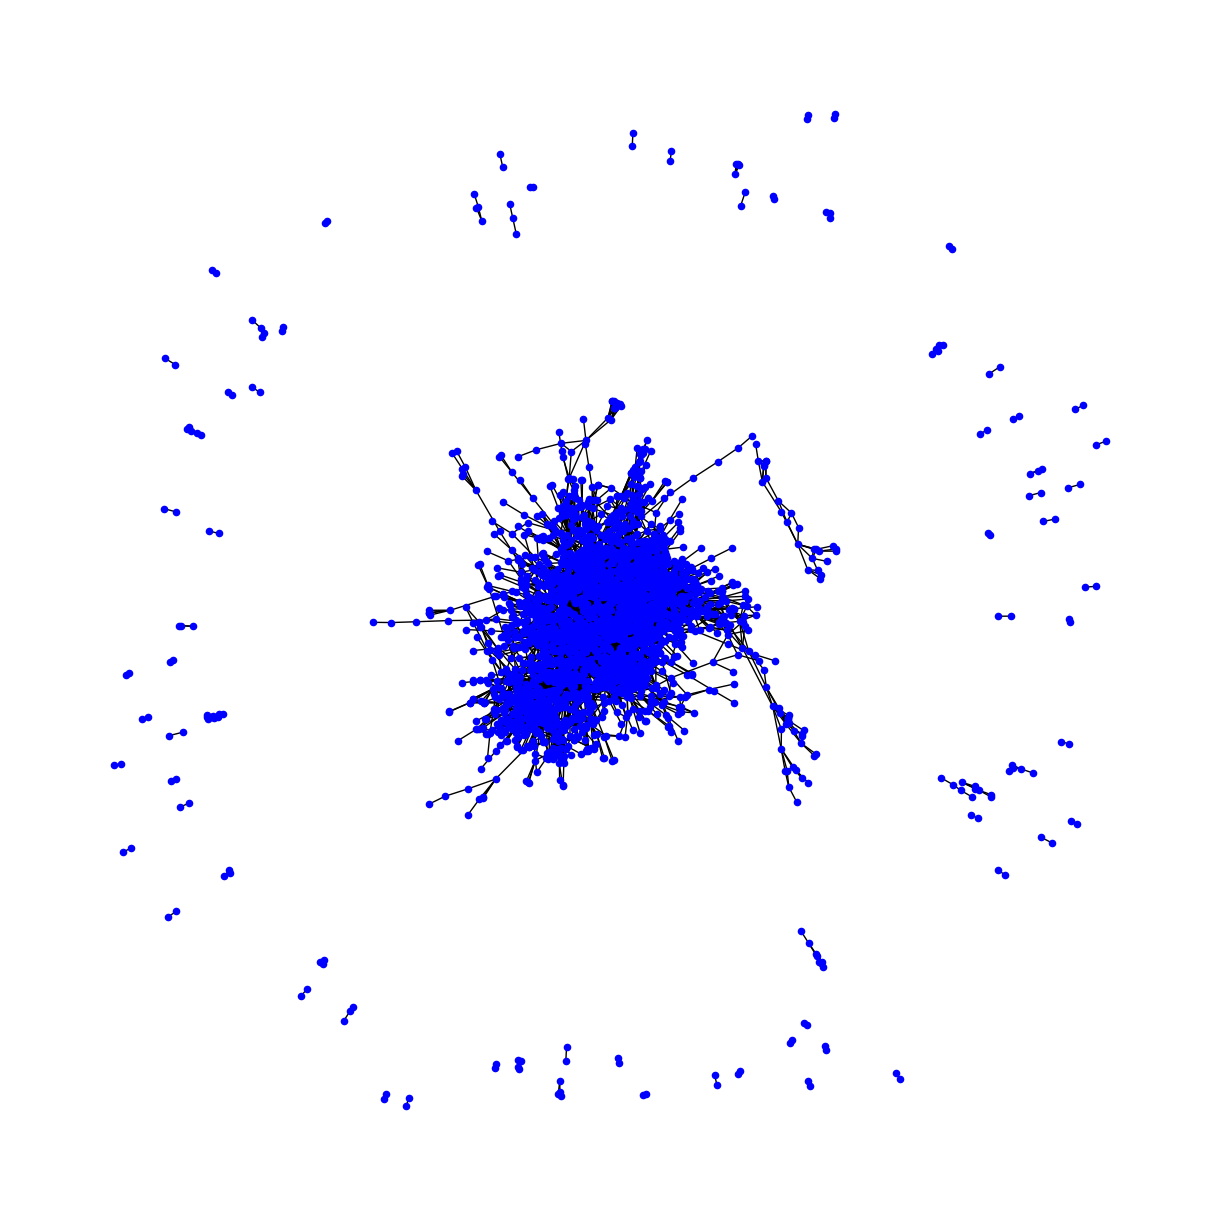

In [6]:
# Convert to a NetworkX graph
G = to_networkx(data, to_undirected=True)

# Draw the graph
plt.figure(figsize=(12, 12))
nx.draw(G, node_size=20, node_color="blue", with_labels=False)
plt.show()

- Checking the normalized node features

In [7]:
# number of node and features per node
print(data.x.shape)

# print the 1820th datapoint(node)'s node features ranging from 1350 to 1400
x_1820 = data.x[1820][1350:1400]

# Scale up, round and scale down
precision = 4
scale_factor = 10**precision
rounded_tensor = torch.round(x_1820 * scale_factor) / scale_factor

# Print the rounded tensor
print(rounded_tensor)

torch.Size([2708, 1433])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0500, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


- Checking the label vectors

In [8]:
# print all the labels for each node
print("All the labels in each node:",data.y)

# total unique labels
unique_labels = torch.unique(data.y)
print("Total labels exist:", unique_labels)

All the labels in each node: tensor([3, 4, 4,  ..., 3, 3, 3])
Total labels exist: tensor([0, 1, 2, 3, 4, 5, 6])


In [9]:
if torch.any(data.y < 0):
    print("Some nodes do not have valid labels.")
else:
    print("All nodes have labels.")

# Alternatively, check for a specific undefined value, e.g., -1:
if torch.any(data.y == -1):
    print("Some nodes have undefined labels marked as -1.")
else:
    print("All nodes have defined labels.")

# Check if any label is NaN
if torch.isnan(data.y).any():
    print("Some node labels are NaN.")
else:
    print("No node labels are NaN.")

All nodes have labels.
All nodes have defined labels.
No node labels are NaN.


- Checking all the masks

In [10]:
print("Train mask:",data.train_mask)
print("Validation mask:",data.val_mask)
print("Test mask:",data.test_mask)

Train mask: tensor([ True, False,  True,  ...,  True, False, False])
Validation mask: tensor([False,  True, False,  ..., False,  True,  True])
Test mask: tensor([False, False, False,  ..., False, False, False])


- Checking the edges

In [11]:
data.edge_index.t()

tensor([[ 633,    0],
        [1862,    0],
        [2582,    0],
        ...,
        [ 598, 2707],
        [1473, 2707],
        [2706, 2707]])

- Visualizing the distribution of degrees on nodes

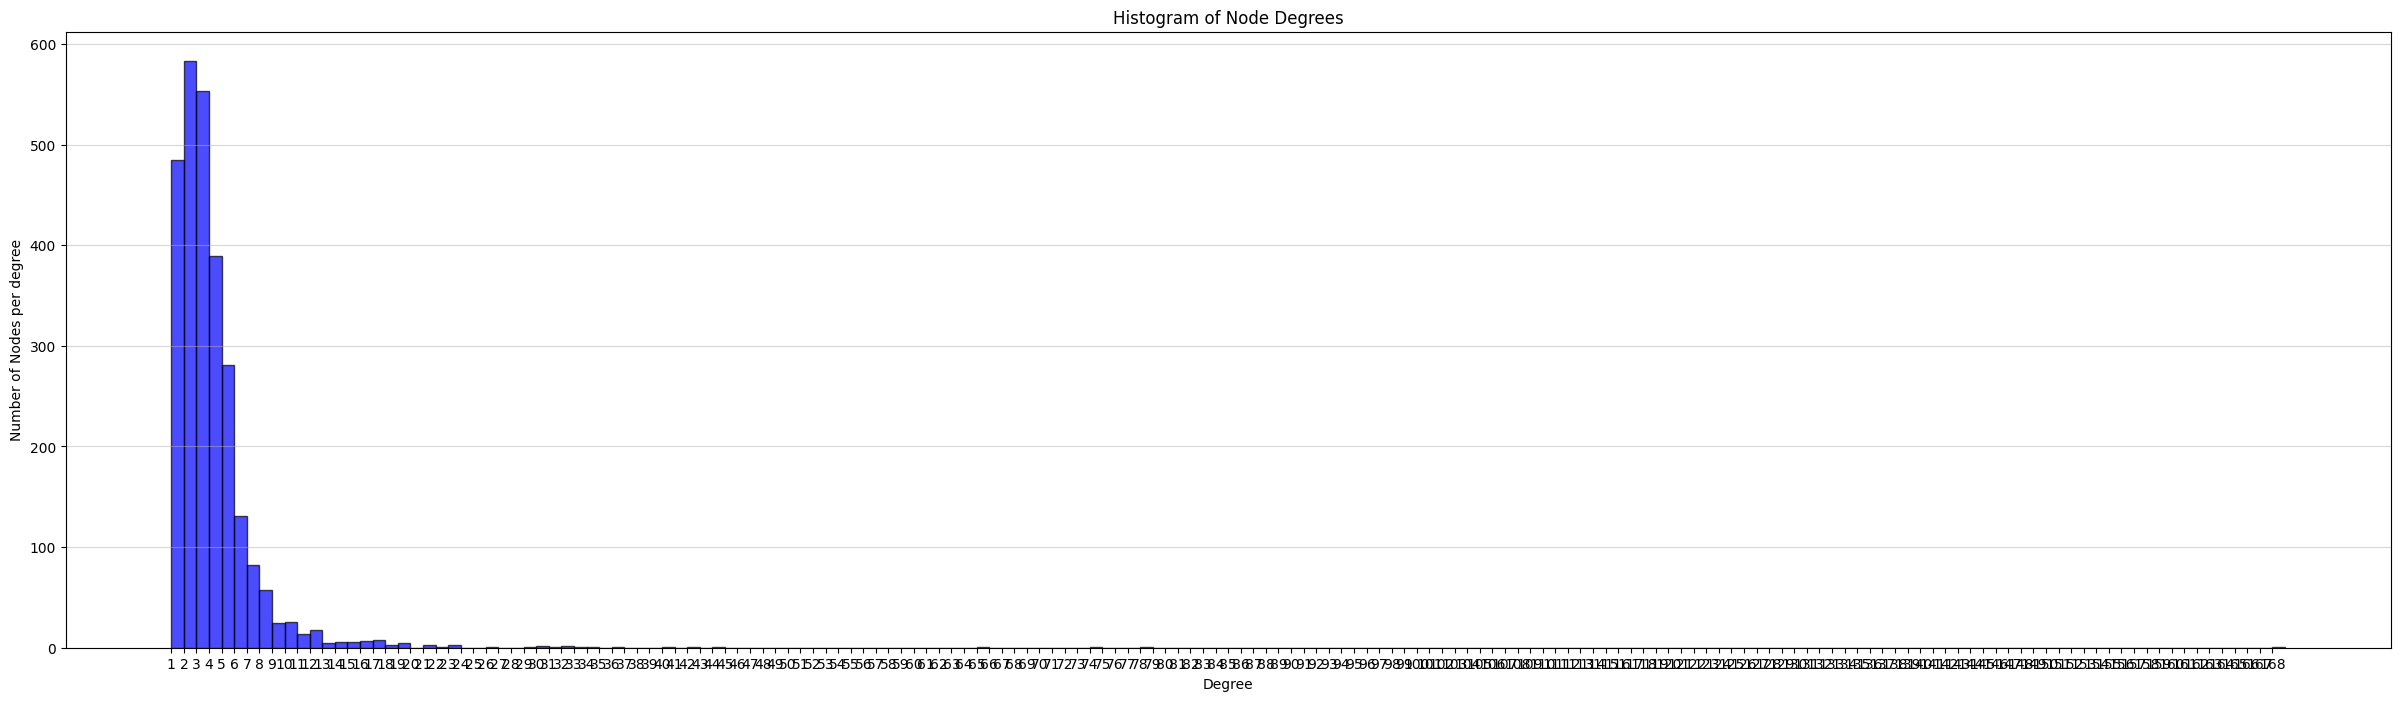

In [12]:
# Calculate node degrees
degrees = [degree for node, degree in G.degree()]

# Plotting the histogram of degrees
plt.figure(figsize=(30, 8))
plt.hist(
    degrees, bins=range(1, max(degrees) + 2), color="blue", alpha=0.7, edgecolor="black"
)
plt.title("Histogram of Node Degrees")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes per degree")
plt.xticks(range(1, max(degrees) + 1))
plt.grid(axis="y", alpha=0.5)

plt.show()

## Graph Convolutional Network Model:

- Define the model architecture

In [13]:
class GCN(torch.nn.Module):
    def __init__(self, n_features, n_classes):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.setup_layers(n_features, n_classes)

    def setup_layers(self, n_features, n_classes):
        # Setup of the GCN layers with specified in/out features
        self.conv1 = GCNConv(n_features, 64)
        self.conv2 = GCNConv(64, 32)
        self.conv3 = GCNConv(32, 16)
        self.out = Linear(16, n_classes)

    def forward(self, x, edge_index):
        # Forward pass through the GCN layers
        x = self.process_layer(x, edge_index, self.conv1, p_dropout=0.8)
        x = self.process_layer(x, edge_index, self.conv2, normalize=True, p_dropout=0.5) # normalizing for smoothening
        x = self.process_layer(x, edge_index, self.conv3, p_dropout=0.3)
        return F.softmax(self.out(x), dim=1)

    def process_layer(self, x, edge_index, conv_layer, normalize=False, p_dropout=0.0):
        # Process each layer with optional normalization
        x = conv_layer(x, edge_index)
        if normalize:
            x = F.normalize(x)
        x = F.relu(x)
        x = F.dropout(x, p=p_dropout, training=self.training)
        return x

- Initializing the model

In [14]:
# Declaring the node classification model
node_classification_model = GCN(
    n_features=n_features,
    n_classes=n_classes,
)

# Use GPU. if not available, then use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
node_classification_model = node_classification_model.to(device)
data = data.to(device)

# Initialize Optimizer and Criterion
optimizer = torch.optim.Adam(
    node_classification_model.parameters(), lr=0.01, weight_decay=5e-4
)
criterion = torch.nn.CrossEntropyLoss()

- Training function

In [15]:
# in training phrase, the whole dataset is sent through, but the losses are evaluated from train set 
def train():
    node_classification_model.train()
    optimizer.zero_grad()
    out = node_classification_model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # Calculate accuracy
    pred = out.argmax(dim=1)
    correct = pred[data.train_mask] == data.y[data.train_mask]
    acc = int(correct.sum()) / int(data.train_mask.sum())

    return loss.item(), acc

- Validation function

In [16]:
# Initialize metrics
precision_metric = Precision(num_classes=n_classes, average="macro", task='multiclass')
recall_metric = Recall(num_classes=n_classes, average="macro", task='multiclass')
f1_score_metric = F1Score(num_classes=n_classes, average="macro", task='multiclass')
auroc_metric = AUROC(num_classes=n_classes, average="macro", task='multiclass')


def evaluate(mask):
    node_classification_model.eval()
    with torch.no_grad():
        out = node_classification_model(data.x, data.edge_index)
        loss = criterion(out[mask], data.y[mask])

        # Convert logits to probabilities (softmax) for AUC-ROC
        probas = torch.softmax(out, dim=1)

        # Update metrics
        pred = out.argmax(dim=1)
        correct = pred[mask] == data.y[mask]
        acc = int(correct.sum()) / int(mask.sum())
        prec = precision_metric(pred[mask], data.y[mask])
        rec = recall_metric(pred[mask], data.y[mask])
        f1 = f1_score_metric(pred[mask], data.y[mask])
        auroc = auroc_metric(probas[mask], data.y[mask])

    return loss.item(), acc, prec.item(), rec.item(), f1.item(), auroc.item()

- Training the model over thousands epoch

In [17]:
# Lists to store metrics
train_losses, train_accs, val_losses, val_accs, val_prec, val_rec, val_f1, val_auroc = (
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
)

for epoch in range(1001):
    train_loss, train_acc = train()
    val_loss, val_acc, val_prec, val_rec, val_f1, val_auroc = evaluate(data.val_mask)

    # Store and print metrics less frequently to save compute
    if epoch % 100 == 0:
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(
            f"Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Prec: {val_prec:.4f}, "
            f"Val Rec: {val_rec:.4f}, Val F1: {val_f1:.4f}, Val AUC-ROC: {val_auroc:.4f}"
        )

Epoch: 000, Train Loss: 1.9392, Train Acc: 0.2933, Val Loss: 1.9310, Val Acc: 0.3063, Val Prec: 0.0438, Val Rec: 0.1429, Val F1: 0.0670, Val AUC-ROC: 0.5483
Epoch: 100, Train Loss: 1.7023, Train Acc: 0.4473, Val Loss: 1.7024, Val Acc: 0.4189, Val Prec: 0.1192, Val Rec: 0.2608, Val F1: 0.1591, Val AUC-ROC: 0.7492
Epoch: 200, Train Loss: 1.4639, Train Acc: 0.7247, Val Loss: 1.4197, Val Acc: 0.7616, Val Prec: 0.5384, Val Rec: 0.6080, Val F1: 0.5681, Val AUC-ROC: 0.8902
Epoch: 300, Train Loss: 1.4403, Train Acc: 0.7380, Val Loss: 1.3892, Val Acc: 0.7781, Val Prec: 0.5447, Val Rec: 0.6275, Val F1: 0.5830, Val AUC-ROC: 0.8889
Epoch: 400, Train Loss: 1.4159, Train Acc: 0.7613, Val Loss: 1.4029, Val Acc: 0.7649, Val Prec: 0.5394, Val Rec: 0.6170, Val F1: 0.5745, Val AUC-ROC: 0.8870
Epoch: 500, Train Loss: 1.3885, Train Acc: 0.7920, Val Loss: 1.3426, Val Acc: 0.8278, Val Prec: 0.6911, Val Rec: 0.7326, Val F1: 0.7107, Val AUC-ROC: 0.9344
Epoch: 600, Train Loss: 1.3776, Train Acc: 0.8087, Val Los

- Plot of evaluation metrics (loss and accuracy)

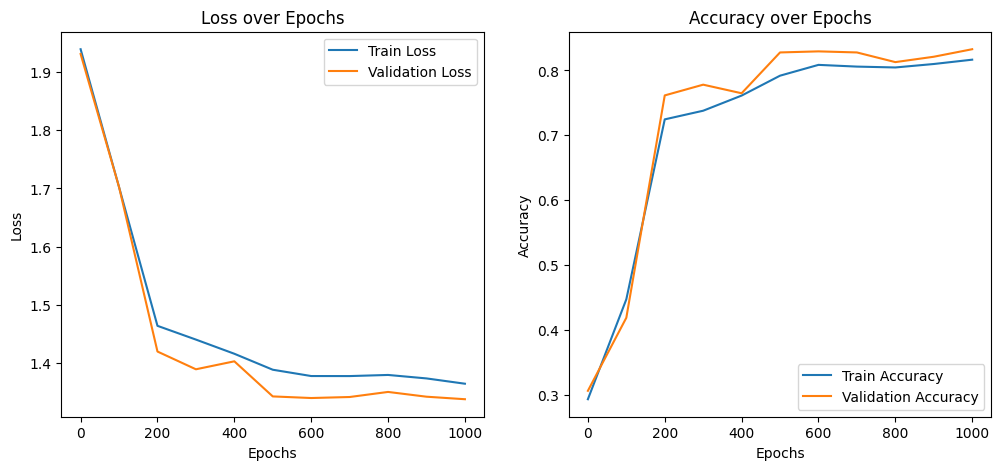

In [18]:
epochs = range(0, 1001, 100)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Train Accuracy")
plt.plot(epochs, val_accs, label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

- Evaluating the accuracy of the model over test set

In [19]:
# Evaluate on the test set at the end
test_loss, test_accuracy, test_prec, test_rec, test_f1, test_auroc = evaluate(
    data.test_mask
)
# Creating a DataFrame to display the results
results_df = pd.DataFrame(
    {
        "Metric": ["Loss", "Accuracy", "Precision", "Recall", "F1 Score", "AUC-ROC"],
        "Value": [
            f"{test_loss:.4f}",
            f"{test_accuracy:.4f}",
            f"{test_prec:.4f}",
            f"{test_rec:.4f}",
            f"{test_f1:.4f}",
            f"{test_auroc:.4f}",
        ],
    }
)

print("Test Set Evaluation Results:")
print(tabulate(results_df, headers="keys", tablefmt="pretty", showindex=False))

Test Set Evaluation Results:
+-----------+--------+
|  Metric   | Value  |
+-----------+--------+
|   Loss    | 1.3386 |
| Accuracy  | 0.8262 |
| Precision | 0.6954 |
|  Recall   | 0.7475 |
| F1 Score  | 0.7193 |
|  AUC-ROC  | 0.9321 |
+-----------+--------+


- Class accuracy evaluation function

In [20]:
def evaluate_class_accuracy(mask):
    node_classification_model.eval()
    with torch.no_grad():
        out = node_classification_model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = pred[mask] == data.y[mask]
        total = mask.sum()

        class_correct = [0] * n_classes
        class_total = [0] * n_classes

        for i in range(n_classes):
            class_mask = data.y[mask] == i
            class_correct[i] = (
                (pred[mask][class_mask] == data.y[mask][class_mask]).sum().item()
            )
            class_total[i] = class_mask.sum().item()

        class_accuracy = [
            c / t if t != 0 else 0 for c, t in zip(class_correct, class_total)
        ]

    return class_accuracy

- Bar chart of the class accuracy

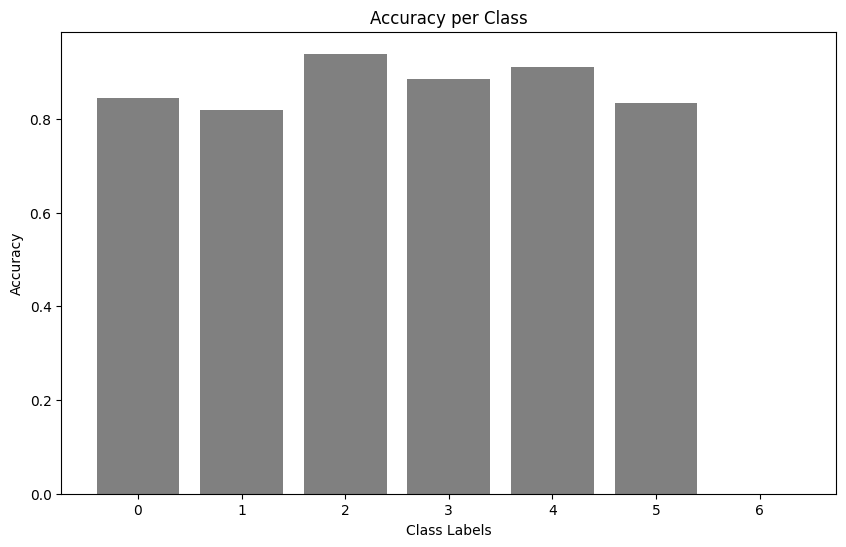

In [21]:
class_accuracies = evaluate_class_accuracy(data.test_mask)

labels = range(n_classes)  
plt.figure(figsize=(10, 6))
plt.bar(labels, class_accuracies, color="grey")
plt.xlabel("Class Labels")
plt.ylabel("Accuracy")
plt.title("Accuracy per Class")
plt.xticks(labels)  
plt.show()

- Visualizing the embeddings in 2D space

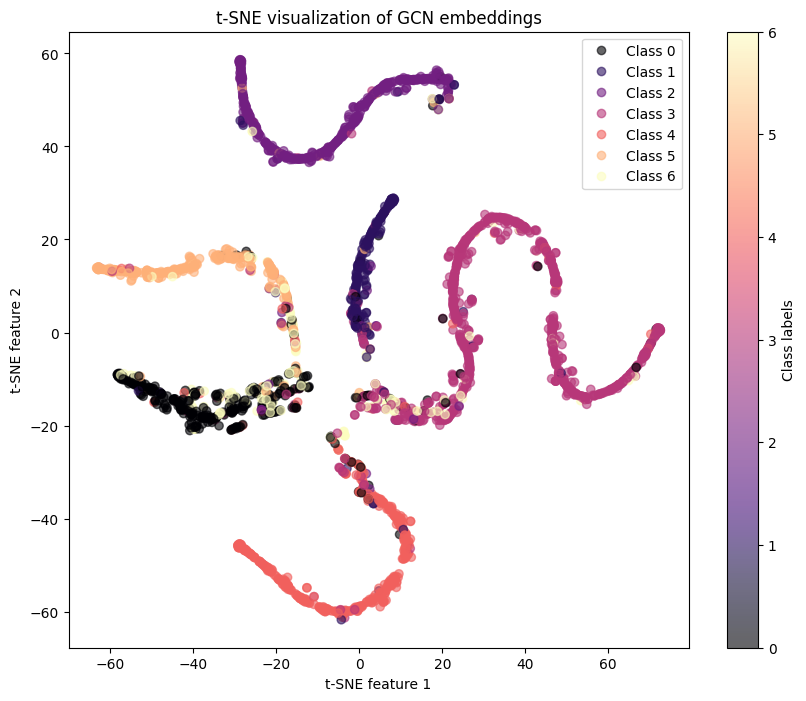

In [22]:
def get_embeddings(data):
    node_classification_model.eval()
    with torch.no_grad():
        embeddings = node_classification_model(
            data.x.to(device), data.edge_index.to(device)
        )
    return embeddings


# Extract embeddings
embeddings = get_embeddings(data)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings.cpu().numpy())

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=data.y.cpu().numpy(),
    cmap="magma",
    alpha=0.6,
)
plt.colorbar(scatter, label="Class labels")
plt.title("t-SNE visualization of GCN embeddings")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.legend(
    handles=scatter.legend_elements()[0],
    labels=[f"Class {i}" for i in range(n_classes)],
)
plt.show()

- Observing some prediction over the model over 20 samples

In [23]:
def predict_random_nodes(model, data, num_samples=20):
    # Ensure the model is in evaluation mode
    model.eval()

    # Randomly select nodes
    all_nodes = np.arange(data.num_nodes)
    selected_indices = np.random.choice(all_nodes, size=num_samples, replace=False)

    # Get predictions
    with torch.no_grad():
        out = model(data.x.to(device), data.edge_index.to(device))
        pred = out.argmax(dim=1)  # Get the class with the highest probability

    # Extract true labels and predicted labels
    predicted_labels = pred[selected_indices].cpu().numpy()
    true_labels = data.y[selected_indices].cpu().numpy()

    return selected_indices, predicted_labels, true_labels


# Use the function
selected_nodes, preds, trues = predict_random_nodes(node_classification_model, data)

# Create a DataFrame to display results
df = pd.DataFrame(
    {"Node ID": selected_nodes, "Predicted Label": preds, "True Label": trues}
)

print(df)

    Node ID  Predicted Label  True Label
0       703                5           5
1      2274                5           0
2      1526                0           0
3       298                3           3
4       716                3           3
5      2429                1           1
6       201                3           3
7       686                2           2
8      1651                1           1
9       989                0           0
10      337                2           2
11     1710                2           2
12     2486                3           3
13      853                2           2
14     1048                3           3
15     2046                1           1
16      186                0           0
17      484                1           1
18     2560                2           2
19      333                4           2
